# First step : preprocessing of data

### Import libraries and preprocessing script

In [4]:
import sys
import numpy as np
from tqdm import tqdm
import nibabel
from preprocessing import load_and_mask_miyawaki_data
from plots import plt_fmri_stim
import matplotlib.pyplot as plt

### Preprocess

In [5]:
fmri_data, stimuli, fmri_figures_data, stimuli_figures, masker = load_and_mask_miyawaki_data()

Preprocessing data...

The shape of the masked data is (20, 145, 5438)
Preprocessed fMRI data: 2860 samples x 5438 voxels
Preprocessed stimuli data: 2860 samples x 100 pixels
1536 geometrical figures


 Done (21.20s).


### Create data sets

In [391]:
from sklearn.model_selection import train_test_split

# Random images avec les carrés noirs : train and validation set
train_to_test_ratio = 0.7
X_train, X_val, Y_train, Y_val = train_test_split(fmri_data, stimuli, 
                                        train_size=train_to_test_ratio, 
                                        test_size=1.0-train_to_test_ratio)

# Test set : geometric images
X_test, Y_test = fmri_figures_data, stimuli_figures

### Simple logistic regression

In [1087]:
from sklearn import linear_model

logreg_table = []
train_accuracy, test_accuracy = np.zeros(100), np.zeros(100)
# loop over pixels
for i,pixel in tqdm(enumerate(np.transpose(Y_train))):
    
    # define logistic regressor
    logreg = linear_model.LogisticRegression(penalty='l2', C=0.05, max_iter = 1500)
    
    # fit training data
    logreg.fit(X_train, pixel)
    
    logreg_table.append(logreg)
    
    # check accuracy
    train_accuracy[i]=logreg.score(X_train,pixel)
    test_accuracy[i]=logreg.score(X_test,np.transpose(Y_test)[i])
    
print('mean accuracy: train, test')
print('liblin: %0.4f, %0.4f' %(np.mean(train_accuracy[i]), np.mean(test_accuracy[i]) ))

100it [10:27,  6.27s/it]

mean accuracy: train, test
liblin: 1.0000, 0.8867


Let's see examples on the figures dataset

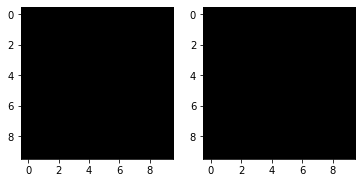

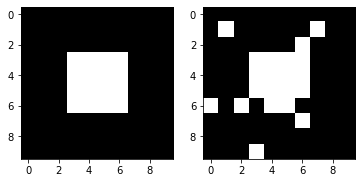

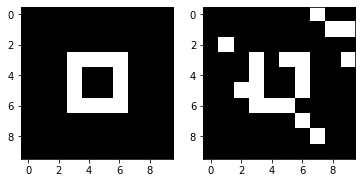

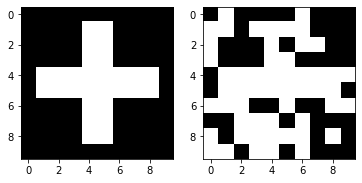

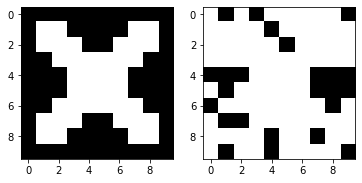

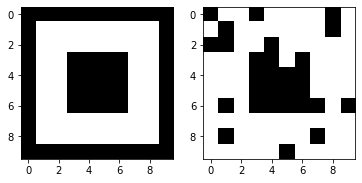

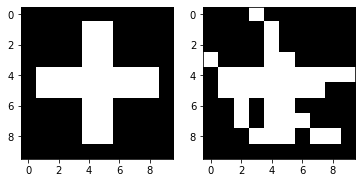

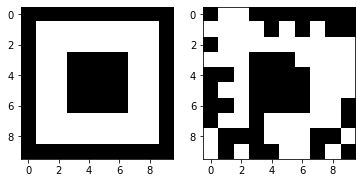

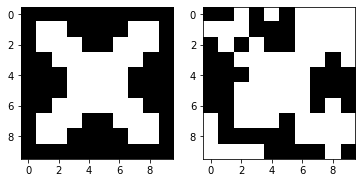

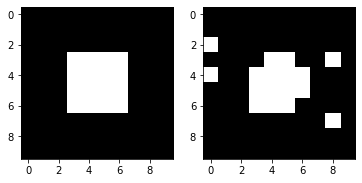

In [1098]:
def logreg_pred(n):
    xtest = X_test[n].reshape(1,-1)
    ytest = np.reshape(Y_test[n],(10,10))
    image = np.zeros(100)
    for i,pixel in enumerate(image) :
        y = logreg_table[i].predict(xtest)
        image[i] = y
    
    image = np.reshape(image,(10,10))

    fig = plt.figure()
    sp1 = plt.subplot(121)
    sp2 = plt.subplot(122)
    sp1.imshow(ytest, cmap = plt.cm.gray, interpolation = 'nearest')
    sp2.imshow(image, cmap = plt.cm.gray, interpolation = 'nearest')
    
for i in range(10):
    logreg_pred(12*i)

The results are quite erratic: let's see what we can do to make them better

### Manipulate stimuli images for multiscale analysis

We want to create the block-averaged stimuli on which we will train logistic regressions later. First we create the lists pixel_indices_(scale) of n-uplets (n being the number of averaged pixels per block) of indices of pixels we want to average together for each scale.

In [1056]:
# Pixel indices to average for 2x2 blocks
pixel_indices_22 = [[10*a+b, 10*a+(b+1), 10*(a+1)+b, 10*(a+1)+(b+1)] for a in range(9) for b in range(9)]

# For 2x1 blocks
pixel_indices_21 = [[(10*b)+ a-1, 10*b + a] for b in range(10) for a in range(10)[1:]]

# For 1x2 blocks
pixel_indices_12 = [[a*10 + b, (a+1)*10 +b] for a in range(9) for b in range(10)]

The following functions allows us to generate the block-averaged versions of the stimuli for the multiscale encoding.

In [1057]:
def preproc_one_stimuli(idx_pxl_toavg, stim) :
    """
    Permits to preproc 1 stimuli figure by averaging some pixels together for the 
    multiscale encoding.
    - idx_pxl_toavg : liste de multiplets d'indices de pixels que l'on souhaite moyenner
                      ensemble. Par ex, pour le 2*2 on a :
                      [[0,1,10,11], [1,2,11,12], ... ,[88,89,98,99]].
    - stimuli: the image
    """
    return np.array([np.average([stim[i] for i in idx]) for idx in idx_pxl_toavg])
    

def preproc_multiple_stimuli(idx_pxl_toavg, stimuli_list) :
    """
    Same as preproc_one_stimuli but for a whole array of images.
    """
    return np.array([[np.average([stim[i] for i in idx]) for idx in idx_pxl_toavg] for stim in stimuli_list])
    
    
def Y_train_newscale(Y_train, idx_pxl_toavg) :
    """
    Creates a new Y_train but with rescaled images 
    Changes greyscale values to classes (integers) : for this, we want to map the values of greyscale to
    integers. We notice that for 4 pixels, only possible values are [0,0.25,0.5,0.75,1]. For 2 pixels, 
    [0,0.5,1]. Etc. By multiplying these grayscale values by the number of pixels we get [0,1,2,3,4] or 
    [0,1,2], etc. Hence the multiplication.
    """
    Y_continuous = preproc_multiple_stimuli(idx_pxl_toavg, Y_train) # with values in [0,1]
    n = len(idx_pxl_toavg[0]) 
    Y_classes = [[int(pixel_val * n) for pixel_val in img] for img in Y_continuous]
    
    return Y_classes

# Training of the logistic regressions at the different scales

We first create a function that trains one logistic regression per block given any kind of block-averaged image.

In [394]:
from sklearn import linear_model

def train_logreg_scale(x_train, y_train, x_test, y_test, scale) :
    """
    Trains a log reg for a certain scale 
    """
    
    logreg_table = []
    size = len(y_train[0])
    
    train_accuracy, test_accuracy = np.zeros(size), np.zeros(size)

    # loop over regularisation strength
    for i, pixel in tqdm(enumerate(np.transpose(y_train))):
    
        # define logistic regressor 
        logreg = linear_model.LogisticRegression(penalty="l2", C=0.05, max_iter = 15000, multi_class='multinomial')#, n_jobs = 2)#, n_jobs=-1)
    
        # fit training data
        logreg.fit(x_train, pixel)
    
        logreg_table.append(logreg)
    
        # check accuracy
        train_accuracy[i]=logreg.score(x_train,pixel)
        test_accuracy[i]=logreg.score(x_test,np.transpose(y_test)[i])
        
    return logreg_table, train_accuracy, test_accuracy

### Train the logistic regressions for each scale

In [395]:
#Prediction functions for initial pixels
[logreg_table_11, train_accuracy_11, test_accuracy_11] = train_logreg_scale(X_train, Y_train, X_test, Y_test, (1,1))

0it [00:00, ?it/s]

100


100it [15:22,  9.22s/it]


In [397]:
# New Y_train for 2*2 block averaged images
Y_train_22, Y_test_22 = Y_train_newscale(Y_train, pixel_indices_22), Y_train_newscale(Y_test, pixel_indices_22)

[logreg_table_22, train_accuracy_22, test_accuracy_22] = train_logreg_scale(X_train, Y_train_22, X_test, Y_test_22,(2,2))

0it [00:00, ?it/s]

81


81it [38:50, 28.77s/it]


In [399]:
print(np.average(train_accuracy_22), np.average(test_accuracy_22))

1.0 0.6879501028806584


In [401]:
# New Y_train for 2*1 block averaged images
Y_train_21, Y_test_21 = Y_train_newscale(Y_train, pixel_indices_21),  Y_train_newscale(Y_test, pixel_indices_21)
            
[logreg_table_21, train_accuracy_21, test_accuracy_21] = train_logreg_scale(X_train, Y_train_21, X_test, Y_test_21,(2,1))

0it [00:00, ?it/s]

90


90it [25:48, 17.20s/it]


In [1058]:
print(np.average(train_accuracy_21), np.average(test_accuracy_21))

1.0 0.7951967592592593


In [405]:
# New Y_train for 1*2 block averaged images
Y_train_12, Y_test_12 = Y_train_newscale(Y_train, pixel_indices_12),  Y_train_newscale(Y_test, pixel_indices_12)

[logreg_table_12, train_accuracy_12, test_accuracy_12] = train_logreg_scale(X_train, Y_train_12, X_test, Y_test_12,(1,2))

0it [00:00, ?it/s]

90


90it [26:10, 17.45s/it]


In [1059]:
print(np.average(train_accuracy_12), np.average(test_accuracy_12))

1.0 0.7885778356481481


### Check local accuracy

We create a plot giving the average accuracy per pixel for each block averaging scale.

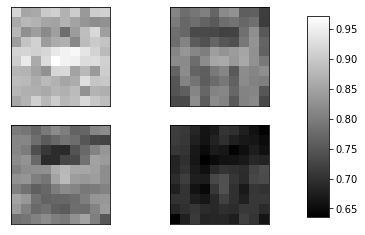

In [1060]:
# Some loops are not optimized for readability since the running time is quite short.

fig = plt.figure()
sp1 = plt.subplot(221)
sp2 = plt.subplot(222)
sp3 = plt.subplot(223)
sp4 = plt.subplot(224)

sbplts = [sp1, sp2, sp3, sp4] 
scales = [11, 12, 21, 22] 
px_indices = [0,pixel_indices_12,pixel_indices_21,pixel_indices_22] 
test_accuracy_list = [test_accuracy_11, test_accuracy_12, test_accuracy_21, test_accuracy_22]  
img_accuracy = [test_accuracy_11]


for i in range(1,4) :
    img_accuracy.append(block_to_100px([test_accuracy_list[i]], px_indices[i], normalize = False)[0])

values = []
for i in img_accuracy :
    for j in range(len(i)) :
        values.append(i[j])

acc_max = max(values) 
acc_min = min(values)

for i, sub in enumerate(sbplts) : 
    if i != 0 :
        plot1 = sub.imshow(np.reshape(img_accuracy[i],(10,10)), cmap = plt.cm.gray, vmax = acc_max, vmin = acc_min)
        sub.set_xticks([])
        sub.set_yticks([])
    else :
        sub.imshow(np.reshape(img_accuracy[i],(10,10)), cmap = plt.cm.gray, vmax = acc_max, vmin = acc_min)
        sub.set_xticks([])
        sub.set_yticks([])
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plot1, cax=cbar_ax)

plt.savefig('./figures/Accuracy/block_averaged_accuracy.png')

# Application of the model to the validation set for optimization of the combination of predictions

We create functions that allow us to plot predicted images.

In [1066]:
def block_to_100px(y_block, pixel_indices_shape, normalize = True) :
    """
    Make the y_block list of overlapping block averaged images with shape nxm 
    (2x2, 2x1 or 1x2) to a list of 100-pixels images. The contributions of overlapping
    blocks are simply averaged for each pixel, with equal weights for each block.
    
    FINAL IMAGE HAS VALUES BETWEEN 0 (black) AND 1 (white) IF NORMALIZE = TRUE
    
    - y_block : list of block values for (predicted or not) images
    - shape : shape of block (2*1 is (2,1) for instance)
    - pixel_indices_shape : list of pixel indices contained in each block (e.g. the first
      block of 2x2 block avgd image contains pixels of indices [0,1,10,11])
    """

    # First, depending on the format, we make a list of the indices of the 
    # blocks we need to average toegether (since not all pixels have the same
    # number of blocks contributing --- and also that their locations are not obvious)
    # block_to_avg[i] : indices of blocks to avg together to make pixel i
    
    block_to_avg = []
    for pixel in range(100) : 
        pixel_blocks = []
        for i, block in enumerate(pixel_indices_shape) :
            if pixel in block :
                pixel_blocks.append(i)
        block_to_avg.append(pixel_blocks)

    # Now we make each image a 100-pixels image instead of a several overlapping blocks image
    
    if normalize == True :
        y_100 = [[np.average([img[block] for block in block_to_avg[pixel]]) for pixel in range(100)] for img in y_block]
        y_100 = [[x/max(img) if max(img) != 0 else 0 for x in img] for img in y_100]
    else :
        y_100 = [[np.average([img[block] for block in block_to_avg[pixel]]) for pixel in range(100)] for img in y_block]
    
    return np.array(y_100)


def weighted_sum(weights, images, i) :
    """
    Just a linear combination of values of different images given different weights
    i : index of pixel
    """

    [W11, W12, W21, W22] = weights
    [im11, im12, im21, im22] = images
    
    return W11[i] * im11[i] + W12[i] * im12[i] + W21[i] * im21[i] + W22[i] * im22[i]


def avgd_imag(weights, images, binarized = False) :
    """
    Returns averaged image given weights
    Can be binarized if binarized = True
    """
    if binarized == False :
        return np.array([weighted_sum(weights, images, px) for px in range(100)])
    else :
        return np.array([np.round(weighted_sum(weights, images, px),0) for px in range(100)])


def avg_all_images(weights, images) :
    """
    Averages all images 4 by 4 with the corresponding weights
    """
    
    [y11, y12, y21, y22] = images
    groups = [[y11[i],y12[i],y21[i],y22[i]] for i in range(len(y11))] #groups of predicted images corresponding to the same fMRI
    
    return np.array([avgd_imag(weights, groups[i]) for i in range(len(groups))])

## Linear regression for optimization of the weights

Each reconstructed pixel is a weighted sum of the predictions for each scale of block-averaging. We want to find the best weights to get a final image as close as possible to the stimuli.

First, we make the predictions on the validation set of random images using the previously trained logistic regressions.

In [413]:
# Validation set predictions of geometric shapes data set
pred_val_22 = predict_from_fmri(logreg_table_22, X_val)
pred_val_12 = predict_from_fmri(logreg_table_12, X_val)
pred_val_21 = predict_from_fmri(logreg_table_21, X_val)
pred_val_11 = predict_from_fmri(logreg_table_11, X_val)

In [416]:
# Make predictions images of 10x10 pixels rather than a set of blocks
pred_val22 = block_to_100px(pred_val_22, pixel_indices_22)
pred_val21 = block_to_100px(pred_val_21, pixel_indices_21)
pred_val12 = block_to_100px(pred_val_12, pixel_indices_12)
pred_val11 = pred_val_11

We can plot those predictions for a rapid check. In principle, if the logregs are well trained, we should (even with the equal weights, not the optimized ones) find something coherent given the test accuracy.

Text(0.5, 1.0, 'Original stimuli')

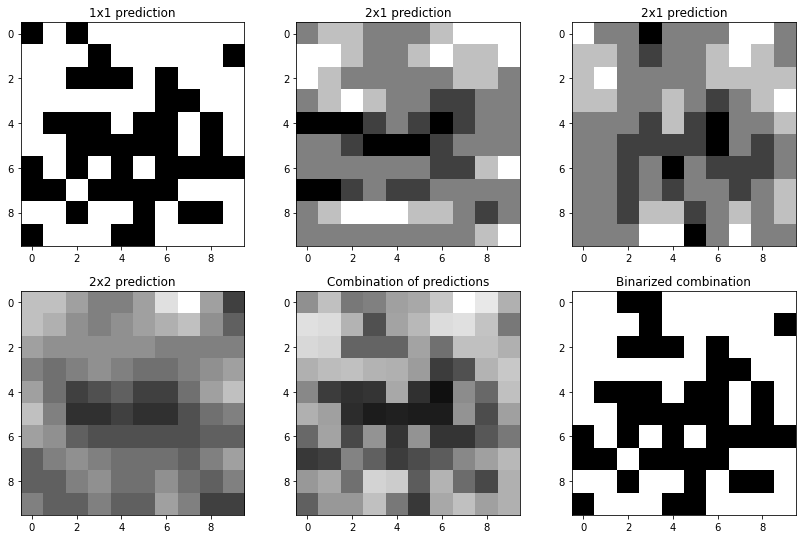

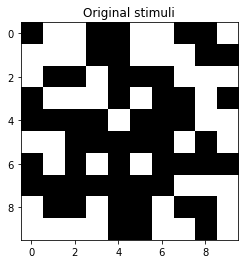

In [1080]:
n = 12

im = [pred_val11[n], pred_val12[n], pred_val21[n], pred_val22[n]]
W = [np.ones(100)*0.25]*4

av = avgd_imag(W, im)
binar = avgd_imag(W, im, binarized = True)

fig = plt.figure(figsize=(14,14))
sp1 = plt.subplot(331)
sp2 = plt.subplot(332)
sp3 = plt.subplot(333)
sp4 = plt.subplot(334)
sp5 = plt.subplot(335)
sp6 = plt.subplot(336)

sp1.imshow(np.reshape(pred_val11[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin = 0, vmax = 1)
sp1.set_title("1x1 prediction")
sp2.imshow(np.reshape(pred_val21[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin = 0, vmax = 1)
sp2.set_title("2x1 prediction")
sp3.imshow(np.reshape(pred_val12[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin = 0, vmax = 1)
sp3.set_title("2x1 prediction")
sp4.imshow(np.reshape(pred_val22[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin = 0, vmax = 1)
sp4.set_title("2x2 prediction")
sp5.imshow(np.reshape(av,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin = 0, vmax = 1)
sp5.set_title("Combination of predictions")
sp6.imshow(np.reshape(binar,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin = 0, vmax = 1)     
sp6.set_title("Binarized combination")

fig2 = plt.figure(figsize=(4,4))
sp = plt.subplot(111)
sp.imshow(np.reshape(Y_val[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin = 0, vmax = 1)
sp.set_title('Original stimuli')

We indeed have something coherent. We now train the linear regression.

In [ ]:
preds = np.array([pred_val22, pred_val21, pred_val12, pred_val11])

linreg = []
coeffs = []
r2 = []

for pixel in range(100) :
    px_pred = [[img[pixel] for img in y] for y in preds]
    px_pred = np.transpose(px_pred)
    px_yval = [img[pixel] for img in Y_val]
    
    model = LinearRegression().fit(px_pred, px_yval)
    r2.append(model.score(px_pred, px_yval))
    linreg.append(model)
    coeffs.append(model.coef_)   

Let's look at the value of the coefficient $r^2$ for each pixel

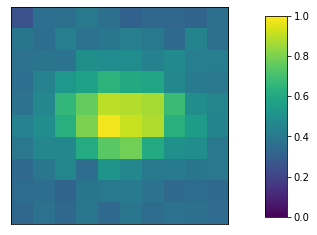

In [1081]:
fig = plt.figure()
ax = plt.subplot(111)
plot = ax.imshow(np.reshape(r2,(10,10)), vmin = 0, vmax = 1)
ax.set_xticks([])
ax.set_yticks([])
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plot, cax=cbar_ax)

plt.savefig('./figures/Accuracy/r2_of_linreg.png')

# Check of the results on the test set of geometrical shapes

Make the predictions for the test set :

In [1099]:
pred_test_22 = predict_from_fmri(logreg_table_22, X_test)
pred_test_12 = predict_from_fmri(logreg_table_12, X_test)
pred_test_21 = predict_from_fmri(logreg_table_21, X_test)
pred_test_11 = predict_from_fmri(logreg_table_11, X_test)

Transformation to 100-pixel images :

In [1100]:
pred_test22 = block_to_100px(pred_test_22, pixel_indices_22)
pred_test21 = block_to_100px(pred_test_21, pixel_indices_21)
pred_test12 = block_to_100px(pred_test_12, pixel_indices_12)
pred_test11 = [np.array(a).flatten() for a in pred_test11]

Average the results over several predictions for a single geometrical shape. We first average the results per series, then for each serie showing the same stimuli.

In [1101]:
indx = []
indx_same_img = []

for i, img in enumerate(Y_test[:]) :
    if np.sum(Y_test[i]) == np.sum(Y_test[i-1]) :
        indx_same_img.append(i)
    else :
        if indx_same_img != [] :
            indx.append(indx_same_img)
            indx_same_img = [i]

In [1102]:
# Average the block predictions

impred = [pred_test11, pred_test12, pred_test21, pred_test22]
averaged_pred = []

for all_scales_images in np.transpose(impred,(1,0,2)) : 
    averaged_image = avgd_imag(np.transpose(coeffs), all_scales_images)
    averaged_image.flatten()
    averaged_pred.append(averaged_image)

In [ ]:
subplots = [sp1, sp2]

for n in range(len(averaged_pred)) :
    fig = plt.figure()
    sp1 = plt.subplot(131)
    sp2 = plt.subplot(132)
   
    true_val = stimuli_figures[n]
    
    sp1.imshow(np.reshape(averaged_pred[n],(10,10)), cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1)#final_images[dupli_idx2[n][0]]
    sp1.set_title("Reconstructed image")
    
    sp2.imshow(np.reshape(true_val,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1)
    sp2.set_title("True image")

 
    for i, ax in enumerate([sp1, sp2, sp3, sp4]) :
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.savefig('./figures/results_vid/result_'+str(n)+'.png')

<ipython-input-1114-60f23d81c555>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


In [884]:
# Average the predictions over several fMRI blabla indices found previously

final_images = []

for indices in indx :
    av_over_fmri = np.average([averaged_pred[i]for i in indices[1:]], axis = 0)
    final_images.append(av_over_fmri)

In [886]:
# Average again each time we have the same image

etiquettes = {} # Ordered list of sum(pixel values) of each shape, once per shape

for i, series in enumerate(indx) : # for the list of indices corresponding to 1 serie of same image
    etiquettes[str(i)] = [val for val in stimuli_figures[series[0]]]

In [887]:
# We want to make an array that contains the list of indices of duplicates in sums

dupli_idx2 = []

for i in range(len(sums)) :
    if i in [x[b] for x in dupli_idx2 for b in range(len(x))] :
        pass
    else :
        dup = [i]
        for j in range(i+1,len(etiquettes)) :
            if etiquettes[str(i)] == etiquettes[str(j)] :
                dup.append(j)
        if len(dup) != 1 :
            dupli_idx2.append(dup)
            dup = []

In [888]:
# Now we average the corresponding images
finals = []

for indices in dupli_idx2 :
    to_average = [final_images[i] for i in indices]
    final_img = np.average(to_average, axis=0)
    finals.append(final_img)

We can now plot the results :

<ipython-input-1085-09a0ff308289>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,10))


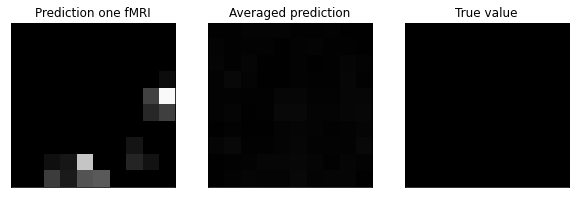

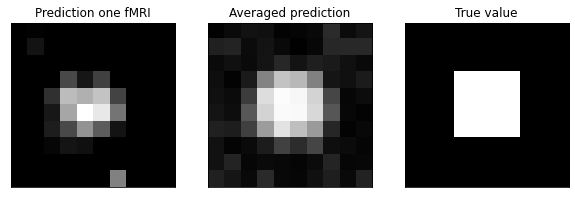

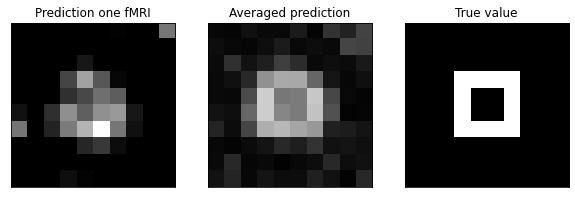

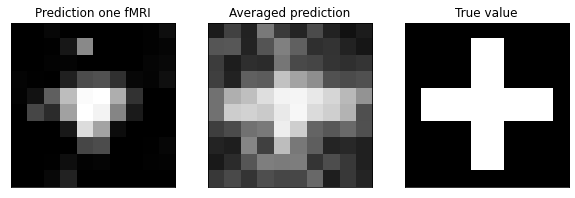

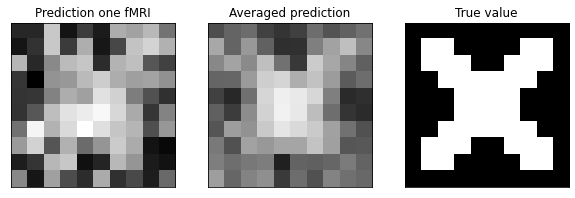

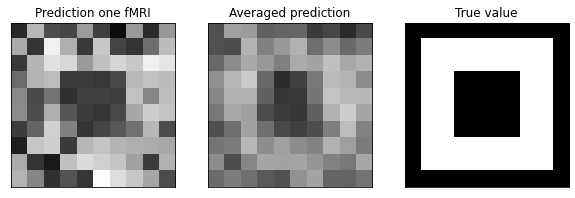

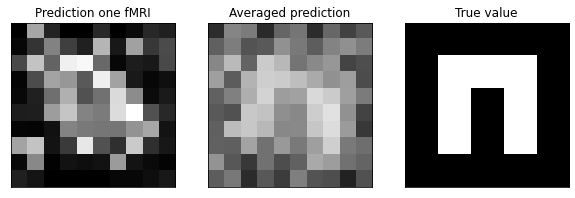

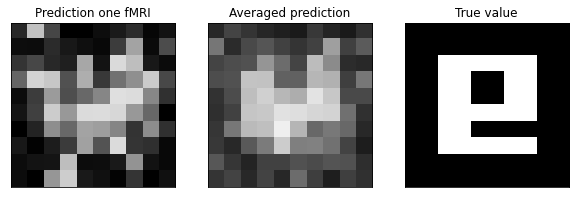

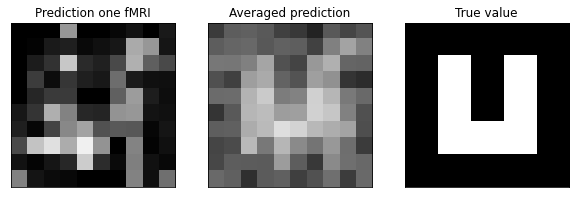

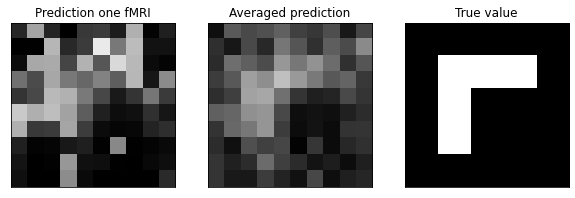

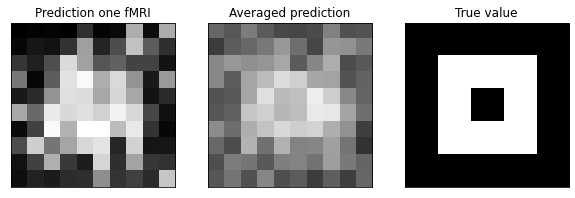

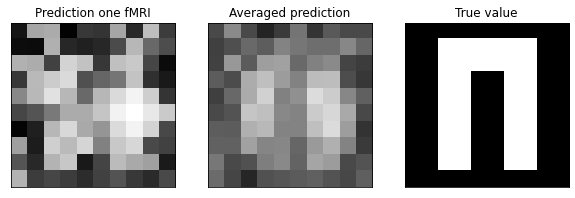

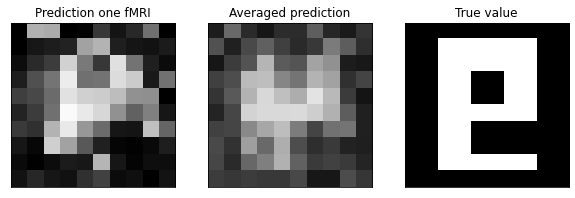

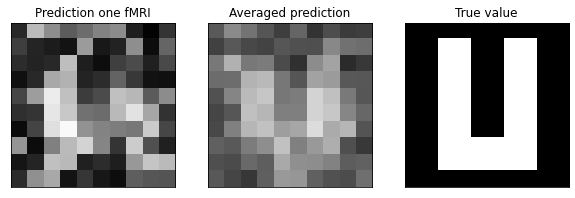

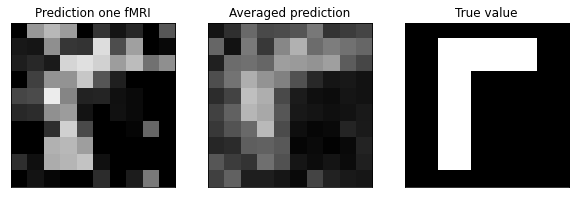

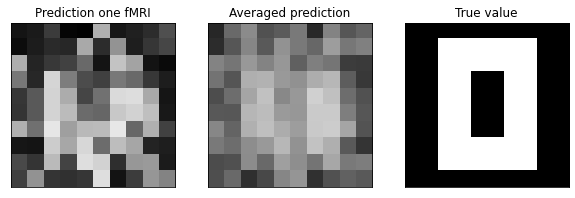

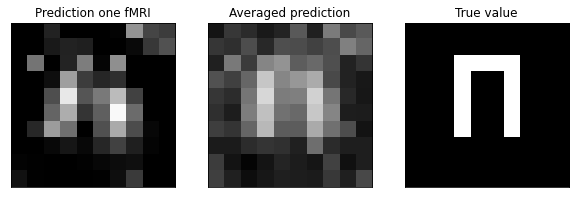

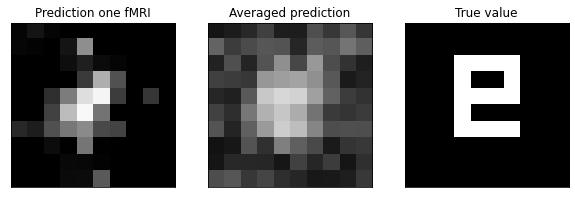

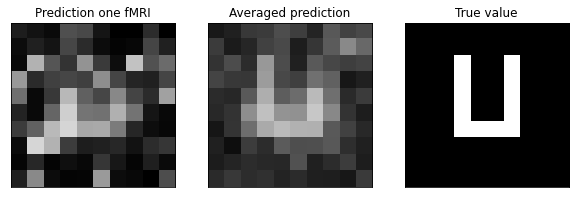

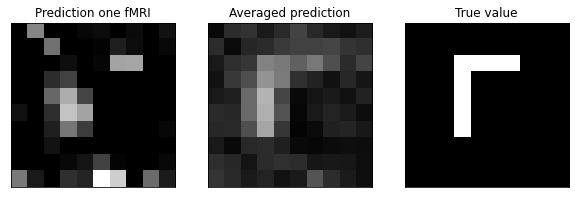

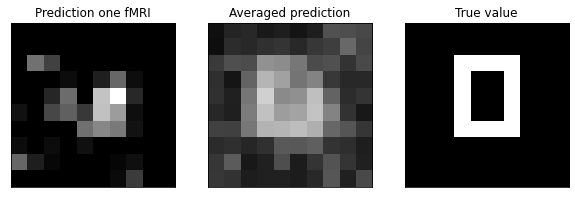

In [1085]:
subplots = [sp1, sp2]
accuracy = []

for n in range(len(dupli_idx2)) :
    fig = plt.figure(figsize=(10,10))
    sp1 = plt.subplot(131)
    sp2 = plt.subplot(132)
    sp3 = plt.subplot(133)
   
    true_val = stimuli_figures[indx[dupli_idx2[n][0]][0]]
    
    sp1.imshow(np.reshape(averaged_pred[indx[dupli_idx2[n][3]][0]],(10,10)), cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1)#final_images[dupli_idx2[n][0]]
    sp1.set_title("Prediction one fMRI")
    
    sp2.imshow(np.reshape(finals[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1)
    sp2.set_title("Averaged prediction")
  
    sp3.imshow(np.reshape(true_val,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1)
    sp3.set_title('True value')
 
    for i, ax in enumerate([sp1, sp2, sp3, sp4]) :
        ax.set_xticks([])
        ax.set_yticks([])
        
    #plt.savefig('./figures/predictions/pred_'+str(n)+'.png')

We can also check the binarized version, and compute the accuracy :

[100, 100, 98, 91, 82, 78, 74, 88, 88, 90, 80, 74, 80, 82, 88, 76, 94, 94, 93, 97, 92]


<ipython-input-1053-3ac3a9bda88a>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,10))


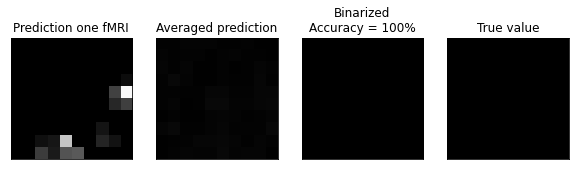

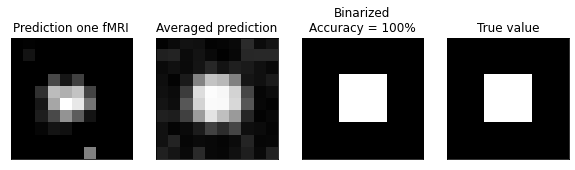

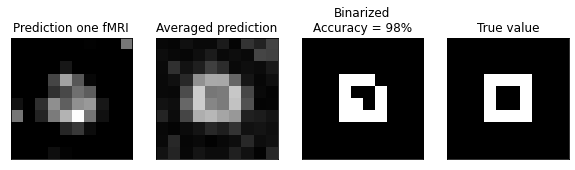

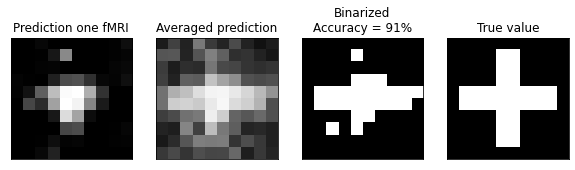

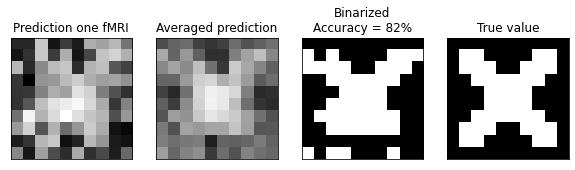

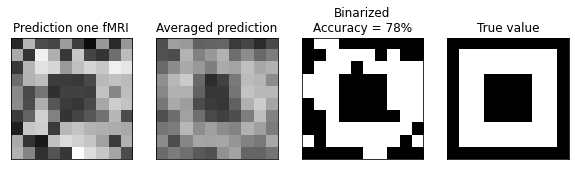

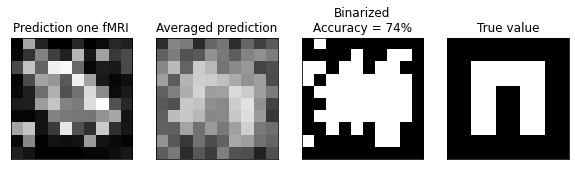

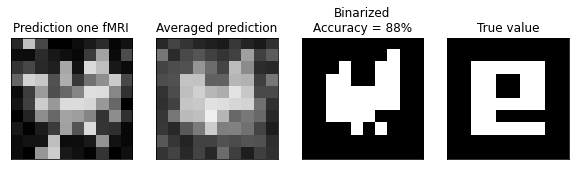

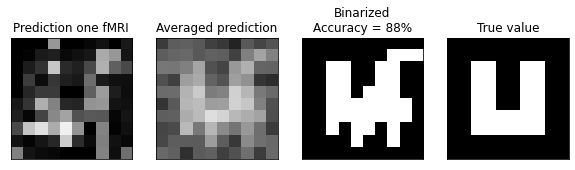

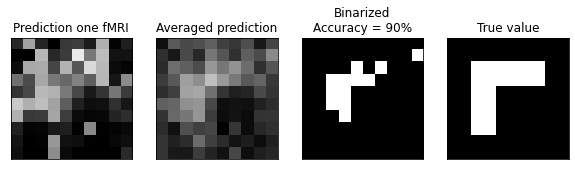

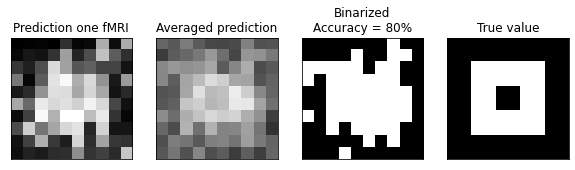

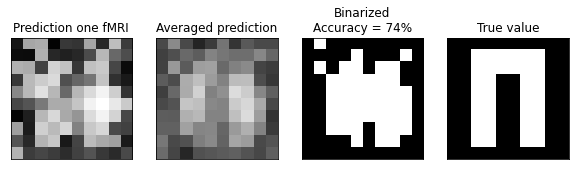

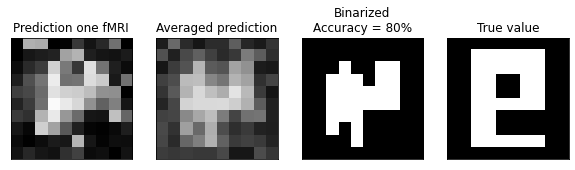

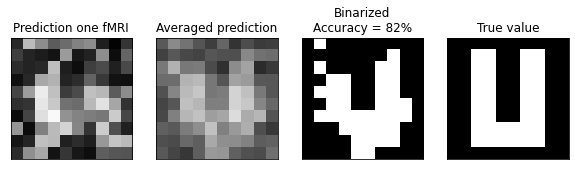

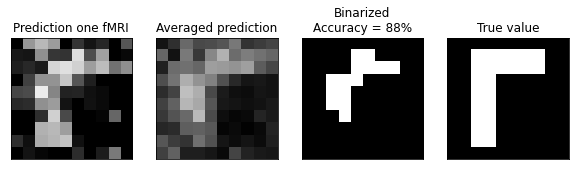

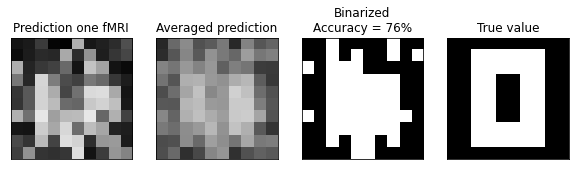

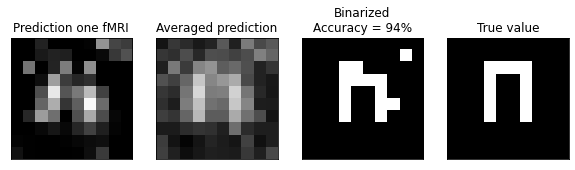

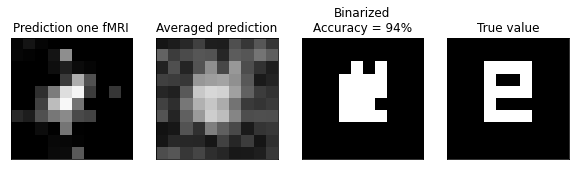

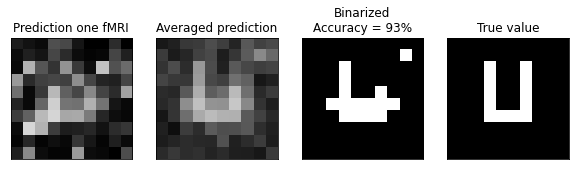

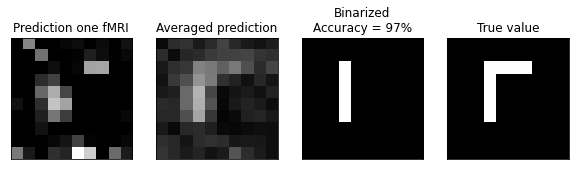

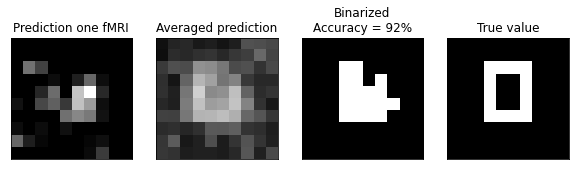

In [1053]:
subplots = [sp1, sp2]
accuracy = []

for n in range(len(dupli_idx2)) :
    fig = plt.figure(figsize=(10,10))
    sp1 = plt.subplot(141)
    sp2 = plt.subplot(142)
    sp3 = plt.subplot(143)
    sp4 = plt.subplot(144)
   
    true_val = stimuli_figures[indx[dupli_idx2[n][0]][0]]
    
    acc = 0
    for j, pixel in enumerate(true_val) :
        if pixel == binarized[j] :
            acc += 1
    accuracy.append(acc)
    
    sp1.imshow(np.reshape(averaged_pred[indx[dupli_idx2[n][3]][0]],(10,10)), cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1)#final_images[dupli_idx2[n][0]]
    sp1.set_title("Prediction one fMRI")
    
    sp2.imshow(np.reshape(finals[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1)
    sp2.set_title("Averaged prediction")
  
    sp3.imshow(np.reshape(binarized, (10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1)
    sp3.set_title("Binarized\nAccuracy = "+str(acc)+'%')
    
    sp4.imshow(np.reshape(true_val,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1)
    sp4.set_title('True value')
    
    for i, ax in enumerate([sp1, sp2, sp3, sp4]) :
        ax.set_xticks([])
        ax.set_yticks([])
        
    #plt.savefig('./figures/prediction_with_accuracy/pred_acc_'+str(n)+'.png')

# Repartition of the weights for each pixel

In [1084]:
weight11, weight22, weight21, weight12 = [], [], [], []

for [w11, w12, w21, w22] in coeffs :
    weight11.append(w11)
    weight22.append(w22)
    weight12.append(w12)
    weight21.append(w21)
    
wmax = max([x[j] for x in coeffs for j in range(4)])
wmin = min([x[j] for x in coeffs for j in range(4)])

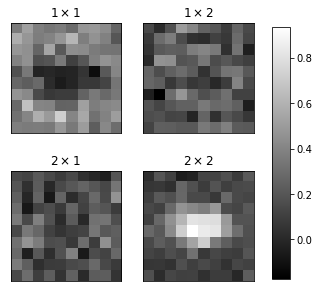

In [857]:
fig = plt.figure(figsize=(5,5))
sp1 = plt.subplot(221)
sp2 = plt.subplot(222)
sp3 = plt.subplot(223)
sp4 = plt.subplot(224)

plot1 = sp1.imshow(np.reshape(weight11,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', label="truc", vmin = wmin, vmax = wmax)
sp2.imshow(np.reshape(weight12,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin = wmin, vmax = wmax)
sp3.imshow(np.reshape(weight21,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest',vmin = wmin, vmax = wmax)
sp4.imshow(np.reshape(weight22,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin = wmin, vmax = wmax)

format_titles = [r'$1\times 1$',r'$1\times 2$', r'$2 \times 1$', r'$2\times 2$']
for i, ax in enumerate([sp1, sp2, sp3, sp4]) :
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(format_titles[i])
        #plot = ax.pcolor(np.reshape(weight11,(10,10)))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, S0.05, 0.7])
fig.colorbar(plot1, cax=cbar_ax)
        
        
plt.savefig('./figures/weights/block_averaged_'+str(n)+'.png')

These are the weights for each pixel and for each kind of block averaging